# Image Deblurring

I implement a deblurring pipeline on GoPro with three models: a residual CNN baseline, a generalized UNet, and a simplified NAFNet.

<img src="images/blur.png">

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


## Setup & Data

In [4]:
from utils import download_from_yadisk, test_model
import os

TARGET_DIR = '.'
FILENAME = "GoPro.zip"

# if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
#     # we are going to download 5.2 gb file, downloading will take some time
#     download_from_yadisk(
#         short_url='https://disk.yandex.ru/d/v7O5TOsstnsscw',
#         filename=FILENAME,
#         target_dir=TARGET_DIR
#     )

In [5]:
# !unzip -qq GoPro.zip

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

from torchvision import transforms
from PIL import Image
import os
from utils import download_from_yadisk, test_model


print(f"GPU: {torch.cuda.is_available()}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU: True


## Dataset

I prepare GoPro train/val/test splits with Albumentations augmentations. I keep shapes and types consistent.

In [7]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path

class GoProDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        blur_path = Path(f"{root_dir}/blur")
        sharp_path = Path(f"{root_dir}/sharp")
        self.blurry_images = [p.name for p in list(blur_path.glob("*.png"))]

    def __len__(self):
        return len(self.blurry_images)

    def __getitem__(self, idx):
        blurry_path = Path(self.root_dir, 'blur', self.blurry_images[idx])
        sharp_path = Path(self.root_dir, 'sharp', self.blurry_images[idx])

        blurry_image = np.array(Image.open(blurry_path).convert('RGB'))
        sharp_image = np.array(Image.open(sharp_path).convert('RGB'))

        if self.transform:
            blurry_image = blurry_image.astype(np.float32)/255.0
            sharp_image = sharp_image.astype(np.float32)/255.0
            augmented = self.transform(image=blurry_image, image1=sharp_image)
            blurry_image = augmented['image']
            blurry_image = blurry_image.to(torch.float32)
            sharp_image = augmented['image1']
            sharp_image = sharp_image.to(torch.float32)

        return blurry_image, sharp_image

transform = A.Compose([
    A.RandomCrop(256, 256, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2(),
], additional_targets={
        'image1': 'image'}, p=1)

transform_test = A.Compose([
    ToTensorV2(),
], additional_targets={
        'image1': 'image'}, p=1)

train_dataset = GoProDataset(root_dir='GoPro/train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=16)

test_dataset = GoProDataset(root_dir='GoPro/test', transform=transform_test)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [18]:
from torch.utils.data import SubsetRandomSampler

# Split the training dataset into training and validation sets
train_size = int(1 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=16,
    pin_memory=True, persistent_workers=True, drop_last=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=16, shuffle=False, num_workers=16,
    pin_memory=True, persistent_workers=True
)
# Keep the test dataloader as it is
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


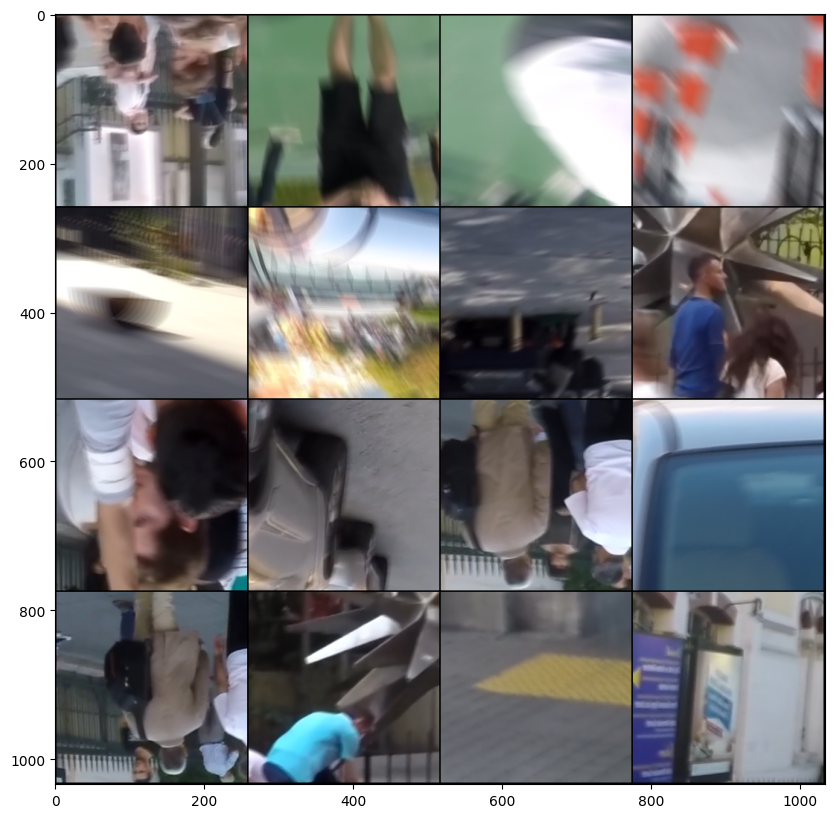

In [19]:
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

## Baseline: Residual CNN

I use a small conv stack (no pooling). The model outputs a residual that I add to the input. Remenicent of early works in [Super-Resolution](https://arxiv.org/abs/1501.00092) and [Denoising](https://arxiv.org/abs/1608.03981)

**Important to note that my network will learn the residual for debluring**  
$I_{deblur}=I_{input} + f_{\theta}(I_{input})$

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvBnBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return x


class Baseline(nn.Module):
    def __init__(self, block, n_blocks=5, n_filters=64):
        super().__init__()
        # Input convolution layer
        self.input_conv = nn.Conv2d(3, n_filters, kernel_size=3, stride=1, padding=1)
        # List of ConvBnBlock modules
        self.conv_blocks = nn.ModuleList([block(n_filters, n_filters) for _ in range(n_blocks)])
        # Output convolution layer
        self.output_conv = nn.Conv2d(n_filters, 3, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        inp = x
        # Apply input convolution
        x = self.input_conv(x)
        # Apply ConvBnBlock modules
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        # Apply output convolution
        x = self.output_conv(x)
        
        # Add the input to the output (residual connection)
        return x + inp

In [11]:
baseline = Baseline(ConvBnBlock)
test_input = torch.rand(4, 3, 256, 256)
test_output = baseline(test_input)
assert test_input.shape == test_output.shape

### PSNR Loss 

I will directly optimize the PSNR quality metric instead of plain MSE  
$PSNR = 10 * \log_{10}(\frac{MAX_I^2}{MSE})$  
In out case the images are normed to [0, 1], so the $MAX_I=1$

When averaging, i first calculate the MSE for each pair of images, only then apply log and after that i average along batch axis.

In [12]:
class PSNRLoss(nn.Module):
    def __init__(self):
        """Peak signal-to-noise ratio loss function?
        """
        super().__init__()
        self.eps = 1e-8  # use eps to prevent 0 in log

    def forward(self, pred, target):

        # along height, width, and channel dimensions
        mse = torch.mean((pred - target) ** 2, dim=(1, 2, 3)) 
        # Apply log and calculate mean
        psnr = 10 * torch.mean(torch.log10(mse + self.eps))

        return psnr

In [14]:
criterion = PSNRLoss()
a = torch.tensor([[[[0.1632, 0.0024, 0.9913, 0.8892],
          [0.5655, 0.4472, 0.4592, 0.2013],
          [0.7722, 0.9089, 0.1708, 0.3654],
          [0.6147, 0.9567, 0.7018, 0.2376]]]])
b = torch.tensor([[[[0.8498, 0.1168, 0.3987, 0.6781],
          [0.7864, 0.9762, 0.3694, 0.9926],
          [0.9000, 0.0293, 0.0454, 0.0984],
          [0.9478, 0.3730, 0.9617, 0.5052]]]])

#simple assert to check the PSNR function
assert torch.isclose(criterion(a, b), torch.tensor(-6.8417))

### Training
Basic training pipeline.

Note that i use gradient clipping, while not required to train the simplest model it will greately help for later parts the work (helps later for deeper models).

In [15]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from utils import get_scheduler
import wandb



In [16]:
import os
os.environ['WANDB_API_KEY'] = "16b6b7fe412116fffbce70dfb1bc6adbd94149ac"

In [17]:
# wandb.init(project="image-deblurring-nafnet", name="run_nafnet_losses_only")


def train_model(model, train_dataloader, optimizer, criterion, scheduler, sch=False, num_epochs=200, checkpoints_path="./checkpoints", use_grad_clip=True):
    # Create checkpoints folder
    PATH = checkpoints_path
    os.makedirs(PATH, exist_ok = True)
    l_2=nn.MSELoss()
    # Training loop
    for epoch in range(num_epochs):
        MSELosses = []
        PSNRs =[]
        for inputs, targets in tqdm(train_dataloader, desc="training..."):
    
            inputs = inputs.to(device)
            targets = targets.to(device)
            #set gradient to zero
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss1 = l_2(outputs, targets)
            PSNRs.append(loss.item())
            MSELosses.append(loss1.item())

            # Backward pass
            loss.backward()

            # Gradient clipping
            if use_grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.05)

            optimizer.step()
        # torch.save({
        #           'epoch': epoch,
        #           'model_state_dict': model.state_dict(),
        #           'optimizer_state_dict': optimizer.state_dict()
        #           }, os.path.join(PATH, f"epoch_{epoch+1}.tar"))

        # Update the learning rate

        if sch : scheduler.step()
        lr = optimizer.param_groups[0]['lr']
        epoch_mse  = float(np.mean(MSELosses))
        epoch_psnr = float(np.mean(PSNRs))

        # ---- W&B: log only the two losses per epoch ----
        # wandb.log({
        #     "train/mse": epoch_mse,
        #     "train/psnr_loss": epoch_psnr, 
        #     "epoch": epoch + 1
        # })

        print(f'\nEpoch {epoch+1}, MSELoss:  {epoch_mse:.6f} , PSNR: {epoch_psnr:.6f},  LR: {lr:.6g} \n')

In [15]:
torch.manual_seed(11)

model = Baseline(ConvBnBlock)
model = model.to(device)

criterion = PSNRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
use_grad_clip = False
scheduler = get_scheduler(optimizer)

train_model(model, train_dataloader, optimizer, criterion, scheduler, num_epochs=32)

training...: 100%|██████████| 118/118 [00:10<00:00, 11.12it/s]



Epoch 1, MSELoss:  0.011719 , PSNR: -22.546608,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:10<00:00, 11.45it/s]



Epoch 2, MSELoss:  0.003928 , PSNR: -25.820603,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:09<00:00, 11.85it/s]



Epoch 3, MSELoss:  0.003612 , PSNR: -26.458774,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:10<00:00, 11.75it/s]



Epoch 4, MSELoss:  0.003622 , PSNR: -26.625429,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:10<00:00, 11.74it/s]



Epoch 5, MSELoss:  0.003572 , PSNR: -26.711152,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:09<00:00, 11.96it/s]



Epoch 6, MSELoss:  0.003695 , PSNR: -26.565377,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:09<00:00, 12.01it/s]



Epoch 7, MSELoss:  0.003555 , PSNR: -26.864920,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:09<00:00, 11.93it/s]



Epoch 8, MSELoss:  0.003578 , PSNR: -26.842001,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:11<00:00, 10.72it/s]



Epoch 9, MSELoss:  0.003538 , PSNR: -26.863912,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:17<00:00,  6.91it/s]



Epoch 10, MSELoss:  0.003393 , PSNR: -27.096661,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:17<00:00,  6.79it/s]



Epoch 11, MSELoss:  0.003558 , PSNR: -26.904804,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:17<00:00,  6.71it/s]



Epoch 12, MSELoss:  0.003505 , PSNR: -26.959562,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:17<00:00,  6.76it/s]



Epoch 13, MSELoss:  0.003520 , PSNR: -26.916516,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:17<00:00,  6.85it/s]



Epoch 14, MSELoss:  0.003523 , PSNR: -27.086816,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:17<00:00,  6.79it/s]



Epoch 15, MSELoss:  0.003435 , PSNR: -27.107181,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:17<00:00,  6.65it/s]



Epoch 16, MSELoss:  0.003484 , PSNR: -27.061714,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:17<00:00,  6.66it/s]



Epoch 17, MSELoss:  0.003601 , PSNR: -26.833497,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:17<00:00,  6.65it/s]



Epoch 18, MSELoss:  0.003513 , PSNR: -26.985056,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:17<00:00,  6.80it/s]



Epoch 19, MSELoss:  0.003457 , PSNR: -27.160430,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:17<00:00,  6.73it/s]



Epoch 20, MSELoss:  0.003418 , PSNR: -27.163608,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:17<00:00,  6.64it/s]



Epoch 21, MSELoss:  0.003519 , PSNR: -27.081447,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:17<00:00,  6.60it/s]



Epoch 22, MSELoss:  0.003433 , PSNR: -27.173147,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:11<00:00, 10.44it/s]



Epoch 23, MSELoss:  0.003458 , PSNR: -27.077535,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:12<00:00,  9.72it/s]



Epoch 24, MSELoss:  0.003507 , PSNR: -27.083045,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:09<00:00, 11.95it/s]



Epoch 25, MSELoss:  0.003513 , PSNR: -27.181608,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:10<00:00, 11.75it/s]



Epoch 26, MSELoss:  0.003487 , PSNR: -27.054707,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:10<00:00, 11.45it/s]



Epoch 27, MSELoss:  0.003423 , PSNR: -27.201759,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:10<00:00, 10.76it/s]



Epoch 28, MSELoss:  0.003570 , PSNR: -27.071680,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:12<00:00,  9.18it/s]



Epoch 29, MSELoss:  0.003484 , PSNR: -27.106296,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:11<00:00,  9.88it/s]



Epoch 30, MSELoss:  0.003434 , PSNR: -27.035410,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:13<00:00,  9.04it/s]



Epoch 31, MSELoss:  0.003402 , PSNR: -27.287516,  LR: 0.0001 



training...: 100%|██████████| 118/118 [00:12<00:00,  9.22it/s]


Epoch 32, MSELoss:  0.003305 , PSNR: -27.330753,  LR: 0.0001 



In [16]:
result,_ = test_model(model, device, test_dataloader)
assert result <= 0.00252


100%|██████████| 634/634 [01:35<00:00,  6.65it/s]

Mean MSE: 0.002464007761845528
Mean PSNR: -27.07500164932732


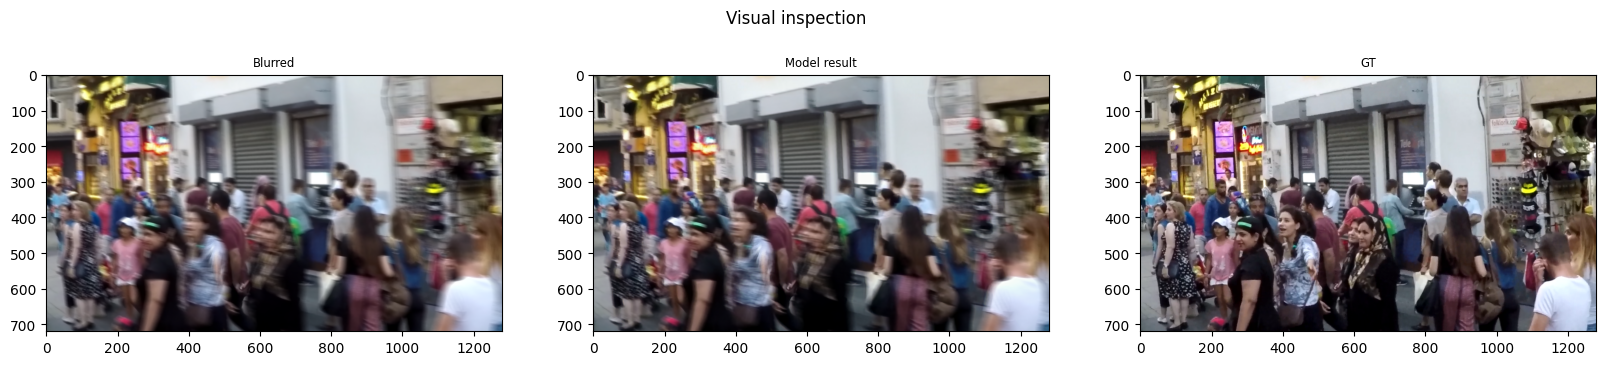

In [17]:
pics = test_dataset[0]
blurred, gt = pics[0], pics[1]
plt.figure(figsize=(20, 4))
plt.suptitle("Visual inspection")
plt.subplot(131)
plt.title("Blurred")
plt.imshow(blurred.permute(1, 2, 0))
plt.subplot(132)
plt.title("Model result")
with torch.no_grad():
    output = model(blurred.unsqueeze(0).to(device)).cpu().squeeze(0).permute(1, 2, 0).numpy()
output = np.clip(output, 0, 1)
plt.imshow(output)
plt.subplot(133)
plt.imshow(gt.permute(1, 2, 0))
plt.title("GT")
plt.show()

## UNet

The next step is to process our image in multiple scales, like the multi-scale methods of old school CV.

The most common model that uses multiple scales is the [UNet](https://arxiv.org/abs/1505.04597), first proposed for medical segmentation and containing many strange design decisions.  
Nonetheless, it has proven to be useful for many CV tasks and is videly used in image and video restoration.

U-Nets are named as such because they have this U-like shape, where the input image is first reduced in dimensionality in the downsizing portion, then increased in dimensionality back to its original size in the upsizing portion.

<img src="images/unet.png">

UNet may be implemented with either concatenation of skip-connections or with the summation.  
The results usually do not differ that much.

In UNet each convolution block is created with two convolutions.  
I implement a simple stack of two layers of convolution with two ReLU activations

In [18]:

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels=None):
        super().__init__()
        out_channels = in_channels if out_channels is None else out_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class UNetDownBlock(nn.Module):
    def __init__(self, chan):
        super().__init__()
        self.avg_pool = nn.AvgPool2d(kernel_size=2)
        self.conv     = nn.Conv2d(chan, chan * 2, kernel_size=1)
    def forward(self, x):
        return self.conv(self.avg_pool(x))

class UNetUpBlock(nn.Module):
    def __init__(self, chan):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv     = nn.Conv2d(chan, chan // 2, kernel_size=1)
    def forward(self, x):
        return self.conv(self.upsample(x))

class GeneralizedUNet(nn.Module):
    def __init__(self, block, downBlock, upBlock, img_channel=3, width=64,
                 middle_blk_num=1, enc_blk_nums=[0,1,2,3], dec_blk_nums=[0,1,2,3]):
        super().__init__()
        self.intro  = nn.Conv2d(img_channel, width, kernel_size=3, padding=1)
        self.ending = nn.Conv2d(width, img_channel, kernel_size=3, padding=1)

        self.encoders = nn.ModuleList([block(width*(2 ** i)) for i in enc_blk_nums])
        self.downs    = nn.ModuleList([downBlock(width*(2 ** i)) for i in enc_blk_nums])
        self.ups      = nn.ModuleList([upBlock(width*(2 ** (i+1))) for i in reversed(dec_blk_nums)])
        self.decoders = nn.ModuleList([block(width*(2 ** (i + 1)), width * (2 ** i)) for i in reversed(dec_blk_nums)])
        self.middle_blks = nn.ModuleList([block(width * (2 ** len(enc_blk_nums))) for _ in range(middle_blk_num)])

    def forward(self, x):
        inp = x
        x = self.intro(x)
        skips = []
        for encoder, downsample in zip(self.encoders, self.downs):
            skips.append(x)
            x = encoder(x)
            x = downsample(x)
        for middle_blk in self.middle_blks:
            x = middle_blk(x)
        for up, decoder, skip in zip(self.ups, self.decoders, reversed(skips)):
            x = up(x)
            x = torch.cat([x, skip], dim=1)
            x = decoder(x)
        x = self.ending(x)
        return x + inp

In [19]:
# Shape sanity checks
block = UNetBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 64, 256, 256])
block_d = UNetDownBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block_d(vec).shape == torch.Size([16, 128, 128, 128])
block_u = UNetUpBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block_u(vec).shape == torch.Size([16, 32, 512, 512])

model = GeneralizedUNet(UNetBlock, UNetDownBlock, UNetUpBlock)
vec = torch.rand(16, 3, 256, 256)
assert model(vec).shape == torch.Size([16, 3, 256, 256])


### Train UNet

In [27]:
torch.manual_seed(11)

model = GeneralizedUNet(UNetBlock, UNetDownBlock, UNetUpBlock)
model = model.to(device)

criterion = PSNRLoss()
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
use_grad_clip = True
scheduler = get_scheduler(optimizer)

train_model(model, train_dataloader, optimizer, criterion, scheduler, sch=True, num_epochs=16, use_grad_clip=use_grad_clip)

training...:   4%|▍         | 24/630 [00:01<00:20, 29.40it/s]

training...: 100%|██████████| 630/630 [00:20<00:00, 30.81it/s]



Epoch 1, MSELoss:  0.004604 , PSNR: -26.244230,  LR: 9.75553e-05 



training...: 100%|██████████| 630/630 [00:20<00:00, 30.67it/s]



Epoch 2, MSELoss:  0.003430 , PSNR: -26.952343,  LR: 9.04604e-05 



training...: 100%|██████████| 630/630 [00:20<00:00, 30.45it/s]



Epoch 3, MSELoss:  0.003397 , PSNR: -27.245673,  LR: 7.94099e-05 



training...: 100%|██████████| 630/630 [00:46<00:00, 13.64it/s]



Epoch 4, MSELoss:  0.003368 , PSNR: -27.220979,  LR: 6.54854e-05 



training...: 100%|██████████| 630/630 [00:49<00:00, 12.63it/s]



Epoch 5, MSELoss:  0.003358 , PSNR: -27.209867,  LR: 5.005e-05 



training...: 100%|██████████| 630/630 [00:49<00:00, 12.74it/s]



Epoch 6, MSELoss:  0.003460 , PSNR: -27.264444,  LR: 3.46146e-05 



training...: 100%|██████████| 630/630 [00:49<00:00, 12.63it/s]



Epoch 7, MSELoss:  0.003320 , PSNR: -27.374865,  LR: 2.06901e-05 



training...: 100%|██████████| 630/630 [00:50<00:00, 12.57it/s]



Epoch 8, MSELoss:  0.003302 , PSNR: -27.362144,  LR: 9.6396e-06 



training...: 100%|██████████| 630/630 [00:27<00:00, 22.92it/s]



Epoch 9, MSELoss:  0.003262 , PSNR: -27.447512,  LR: 2.54473e-06 



training...: 100%|██████████| 630/630 [00:25<00:00, 24.39it/s]



Epoch 10, MSELoss:  0.003105 , PSNR: -27.693198,  LR: 1e-07 



training...: 100%|██████████| 630/630 [00:25<00:00, 25.16it/s]



Epoch 11, MSELoss:  0.003336 , PSNR: -27.489685,  LR: 4.88276e-05 



training...: 100%|██████████| 630/630 [00:30<00:00, 20.36it/s]



Epoch 12, MSELoss:  0.003082 , PSNR: -27.682383,  LR: 4.52802e-05 



training...: 100%|██████████| 630/630 [00:37<00:00, 16.78it/s]



Epoch 13, MSELoss:  0.003308 , PSNR: -27.372044,  LR: 3.97549e-05 



training...: 100%|██████████| 630/630 [00:35<00:00, 17.90it/s]



Epoch 14, MSELoss:  0.003197 , PSNR: -27.493116,  LR: 3.27927e-05 



training...: 100%|██████████| 630/630 [00:36<00:00, 17.22it/s]



Epoch 15, MSELoss:  0.003209 , PSNR: -27.599920,  LR: 2.5075e-05 



training...: 100%|██████████| 630/630 [00:37<00:00, 16.99it/s]


Epoch 16, MSELoss:  0.003275 , PSNR: -27.491590,  LR: 1.73573e-05 



In [28]:
result,_ = test_model(model, device, test_dataloader)
assert result <= 0.00235

100%|██████████| 634/634 [01:55<00:00,  5.50it/s]

Mean MSE: 0.0022981969676053714
Mean PSNR: -27.41946542881812


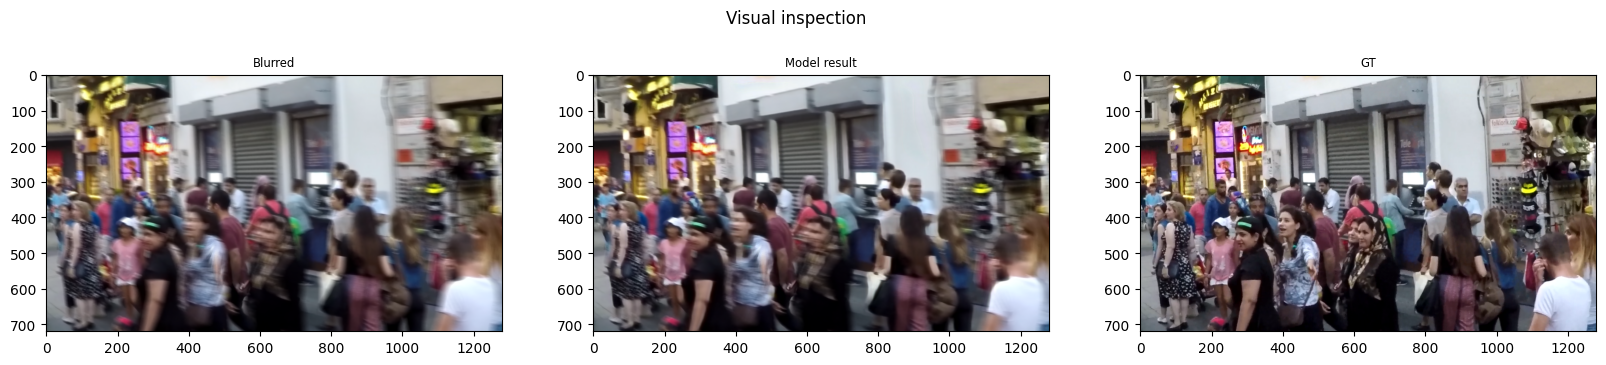

In [29]:
pics = test_dataset[0]
blurred, gt = pics[0], pics[1]
plt.figure(figsize=(20, 4))
plt.suptitle("Visual inspection")
plt.subplot(131)
plt.title("Blurred")
plt.imshow(blurred.permute(1, 2, 0))
plt.subplot(132)
plt.title("Model result")
with torch.no_grad():
    output = model(blurred.unsqueeze(0).to(device)).cpu().squeeze(0).permute(1, 2, 0).numpy()
output = np.clip(output, 0, 1)
plt.imshow(output)
plt.subplot(133)
plt.imshow(gt.permute(1, 2, 0))
plt.title("GT")
plt.show()

## NAFNet

I mentioned that many architectures build upon **UNet** by modifying individual blocks. One notable example is [NAFNet](https://arxiv.org/abs/2204.04676), which for quite some time held state-of-the-art performance in image deblurring even though the authors originally presented it as a baseline model.  

Some of the main design choices behind NAFNet include:  
- Removing traditional nonlinearities (no ReLU, GELU, ELU, etc.)  
- Using a simplified form of channel attention  
- Replacing BatchNorm with LayerNorm  
- Incorporating several training strategies inspired by transformer papers  

In spirit, this approach is somewhat similar to [ConvNeXt](https://arxiv.org/abs/2201.03545), where the authors revisited ResNet and refined it with modern training techniques to achieve state-of-the-art results in classification.  

Now I’ll move on to implementing **NAFNet** 

### Simple gate block

<img src="images/gate.png">

Instead of using regular non-linearities  [NAFNet](https://arxiv.org/abs/2204.04676) proposes the use of "Simple Gates" which perform pointwise multiplication of feature maps.

Simple gate layer splits input feature map in 2 part along the channel axis and multiplies them.

I use [`torch.chunk`](https://pytorch.org/docs/stable/generated/torch.chunk.html) to split the input in 2

In [20]:
class SimpleGate(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        """
            Split the input in 2, along the channel axis
            Return multiplication of these 2 parts
        """
        # Split the input tensor along the channel axis
        part1, part2 = torch.chunk(x, 2, dim=1)
        # Multiply the two parts element-wise
        output = torch.mul(part1, part2)

        return output

In [21]:
block = SimpleGate()
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 32, 256, 256])

### NAFNet up block

In [22]:
class NAFNetUpBlock(nn.Module):
    def __init__(self, channels):
        """NAFNet upsampling block
            conv 1x1 (chan, 2 * chan)
            pixelshuffle(2)

        """
        super(NAFNetUpBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels * 2, kernel_size=1, bias=False)  # Pointwise Convolution to double channel width
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pixel_shuffle(x)
        return x

In [23]:
block = NAFNetUpBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 32, 512, 512])

### NAFNet down block

In [24]:
class NAFNetDownBlock(nn.Module):
    def __init__(self, channels):
        """NAFNet downsampling block
            conv with stride 2, **mind the padding**

        """
        super().__init__()


        self.conv = nn.Conv2d(channels, channels * 2, kernel_size=2, stride=2)


    def forward(self, x):


        x = self.conv(x)
        return x


In [25]:
block = NAFNetDownBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 128, 128, 128])

### Simplified Channel Attention in NAFNet

In regular channel attention mechanisms, the weights for each channel of the input feature map are produced using a small 2-layer MLP.  
The authors of [NAFNet](https://arxiv.org/abs/2204.04676) simplified this step by removing the MLP entirely.  

Instead, they apply global pooling to the feature map and then use a simple linear projection to obtain the channel weights.  
This makes the block lighter and more efficient, while still capturing useful channel information.  

<img src="images/sca.png">

In [26]:
class SCA(nn.Module):
    def __init__(self, in_channels, out_channels):
        """Simplified channel attention module

            adaptiveavgpool to get 1x1 feature map
            conv 1x1 projection layer

        """
        super().__init__()



        self.adaptive_pool = nn.AdaptiveAvgPool2d(1)
        self.sca = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=1,
                  groups=1, bias=True)



    def forward(self, x):
        """
            Return only the attention weights
        """
        att_weights = self.sca(x)
        x = self.adaptive_pool(att_weights)
        return att_weights

In [27]:
block = SCA(64, 32)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 32, 256, 256])

In [28]:
block(vec).shape

torch.Size([16, 32, 256, 256])

### NAFNet block

The diagram shows the intra-block structure:

<img src="images/nafnet_block.png" width=620>

Note the use of learnable skip-connection scales `beta` and `gamma`, use [`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)

<img src="https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html"/>



In [29]:
from utils import LayerNorm2d  # 

class NAFNetBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0.):
        super().__init__()

        dw_channel = c * DW_Expand
        ffn_channel = FFN_Expand * c

        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel,
                               bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        # Simplified Channel Attention
        self.sca = SCA(in_channels=dw_channel // 2, out_channels=dw_channel // 2)

        # SimpleGate
        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)


    def forward(self, inp):


        x = inp

        x = self.norm1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x)
        x = self.conv3(x)

        x = self.dropout1(x)

        y = inp + x * self.beta

        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return y + x * self.gamma

In [30]:
block = NAFNetBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 64, 256, 256])

### NAFNet — full model

In [31]:
class GeneralizedNAFNet(nn.Module):

    def __init__(self,NAFNetBlock, NAFNetDownBlock, NAFNetUpBlock, img_channel=3, width=16, middle_blk_num=1, enc_blk_nums=[], dec_blk_nums=[]):
        super().__init__()
        self.intro = nn.Conv2d(in_channels=img_channel, out_channels=width, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True).to(device)
        self.ending = nn.Conv2d(in_channels=width, out_channels=img_channel, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True).to(device)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.middle_blks = nn.ModuleList().to(device)
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        chan = width
        for num in enc_blk_nums:
            self.encoders.append(
                nn.Sequential(
                    *[NAFNetBlock(chan) for _ in range(num)]
                )
            )
            self.downs.append(
                NAFNetDownBlock(chan)
            )
            chan = chan * 2

        self.middle_blks = \
            nn.Sequential(
                *[NAFNetBlock(chan) for _ in range(middle_blk_num)]
            )

        for num in dec_blk_nums:
            self.ups.append(NAFNetUpBlock(chan)
            )
            chan = chan // 2
            self.decoders.append(
                nn.Sequential(
                    *[NAFNetBlock(chan) for _ in range(num)]
                )
            )

        self.padder_size = 2 ** len(self.encoders)

    def forward(self, inp):
        B, C, H, W = inp.shape
        inp = self.check_image_size(inp)

        x = self.intro(inp)

        encs = []

        for encoder, down in zip(self.encoders, self.downs):
            x = encoder(x)
            encs.append(x)
            x = down(x)

        x = self.middle_blks(x)

        for decoder, up, enc_skip in zip(self.decoders, self.ups, encs[::-1]):
            x = up(x)
            x = x + enc_skip
            x = decoder(x)

        x = self.ending(x)
        x = x + inp

        return x[:, :, :H, :W]

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.padder_size - h % self.padder_size) % self.padder_size
        mod_pad_w = (self.padder_size - w % self.padder_size) % self.padder_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h))
        return x


### Train NAFNet

In [32]:
model = GeneralizedNAFNet(NAFNetBlock, NAFNetDownBlock, NAFNetUpBlock, enc_blk_nums=[1,2,2,28], dec_blk_nums=[2,2,2,1])
model.to(device)
vec = torch.rand(2, 3, 256, 256).to(device)

assert model(vec).shape == torch.Size([2, 3, 256, 256])

In [33]:
torch.cuda.empty_cache()

In [36]:
torch.manual_seed(11)

model = GeneralizedNAFNet(NAFNetBlock, NAFNetDownBlock, NAFNetUpBlock, enc_blk_nums=[1,2,2,28], dec_blk_nums=[2,2,2,1])
model = model.to(device)

criterion = PSNRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
use_grad_clip = True
scheduler = get_scheduler(optimizer)

train_model(model, train_dataloader, optimizer, criterion,scheduler, sch=True, num_epochs=128, use_grad_clip=use_grad_clip)

training...:   0%|          | 0/131 [00:00<?, ?it/s]

training...: 100%|██████████| 131/131 [00:21<00:00,  6.00it/s]



Epoch 1, MSELoss:  0.003611 , PSNR: -26.843241,  LR: 0.000975531 



training...: 100%|██████████| 131/131 [00:21<00:00,  5.96it/s]



Epoch 2, MSELoss:  0.003452 , PSNR: -27.158940,  LR: 0.000904518 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.05it/s]



Epoch 3, MSELoss:  0.003498 , PSNR: -27.225128,  LR: 0.000793913 



training...: 100%|██████████| 131/131 [00:21<00:00,  5.99it/s]



Epoch 4, MSELoss:  0.003425 , PSNR: -27.237442,  LR: 0.000654543 



training...: 100%|██████████| 131/131 [00:21<00:00,  5.98it/s]



Epoch 5, MSELoss:  0.003305 , PSNR: -27.447820,  LR: 0.00050005 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.00it/s]



Epoch 6, MSELoss:  0.003249 , PSNR: -27.472800,  LR: 0.000345557 



training...: 100%|██████████| 131/131 [00:21<00:00,  5.99it/s]



Epoch 7, MSELoss:  0.003267 , PSNR: -27.462643,  LR: 0.000206187 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.05it/s]



Epoch 8, MSELoss:  0.003274 , PSNR: -27.387338,  LR: 9.5582e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.02it/s]



Epoch 9, MSELoss:  0.003102 , PSNR: -27.517771,  LR: 2.45693e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  5.97it/s]



Epoch 10, MSELoss:  0.003176 , PSNR: -27.548372,  LR: 1e-07 



training...: 100%|██████████| 131/131 [00:21<00:00,  5.99it/s]



Epoch 11, MSELoss:  0.003191 , PSNR: -27.584861,  LR: 0.000487815 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.00it/s]



Epoch 12, MSELoss:  0.003209 , PSNR: -27.493995,  LR: 0.000452309 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.00it/s]



Epoch 13, MSELoss:  0.003114 , PSNR: -27.697094,  LR: 0.000397007 



training...: 100%|██████████| 131/131 [00:22<00:00,  5.91it/s]



Epoch 14, MSELoss:  0.003189 , PSNR: -27.472532,  LR: 0.000327322 



training...: 100%|██████████| 131/131 [00:21<00:00,  5.99it/s]



Epoch 15, MSELoss:  0.003122 , PSNR: -27.650510,  LR: 0.000250075 



training...: 100%|██████████| 131/131 [00:22<00:00,  5.92it/s]



Epoch 16, MSELoss:  0.003147 , PSNR: -27.570846,  LR: 0.000172828 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.04it/s]



Epoch 17, MSELoss:  0.003090 , PSNR: -27.699317,  LR: 0.000103143 



training...: 100%|██████████| 131/131 [00:22<00:00,  5.94it/s]



Epoch 18, MSELoss:  0.003076 , PSNR: -27.881586,  LR: 4.7841e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.00it/s]



Epoch 19, MSELoss:  0.003156 , PSNR: -27.711015,  LR: 1.23346e-05 



training...: 100%|██████████| 131/131 [00:24<00:00,  5.44it/s]



Epoch 20, MSELoss:  0.003053 , PSNR: -27.906230,  LR: 1e-07 



training...: 100%|██████████| 131/131 [00:26<00:00,  4.91it/s]



Epoch 21, MSELoss:  0.003010 , PSNR: -27.796134,  LR: 0.000487815 



training...: 100%|██████████| 131/131 [00:26<00:00,  4.97it/s]



Epoch 22, MSELoss:  0.003034 , PSNR: -27.723018,  LR: 0.000452309 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.11it/s]



Epoch 23, MSELoss:  0.003009 , PSNR: -27.825408,  LR: 0.000397007 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.17it/s]



Epoch 24, MSELoss:  0.003118 , PSNR: -27.845069,  LR: 0.000327322 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.07it/s]



Epoch 25, MSELoss:  0.003045 , PSNR: -27.722002,  LR: 0.000250075 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.13it/s]



Epoch 26, MSELoss:  0.003043 , PSNR: -27.856418,  LR: 0.000172828 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.01it/s]



Epoch 27, MSELoss:  0.002975 , PSNR: -27.949493,  LR: 0.000103143 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.12it/s]



Epoch 28, MSELoss:  0.002967 , PSNR: -27.931530,  LR: 4.7841e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.06it/s]



Epoch 29, MSELoss:  0.002837 , PSNR: -28.190597,  LR: 1.23346e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.13it/s]



Epoch 30, MSELoss:  0.002873 , PSNR: -28.191001,  LR: 1e-07 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.07it/s]



Epoch 31, MSELoss:  0.002910 , PSNR: -28.142587,  LR: 0.000487815 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.14it/s]



Epoch 32, MSELoss:  0.002990 , PSNR: -27.877058,  LR: 0.000452309 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.05it/s]



Epoch 33, MSELoss:  0.002940 , PSNR: -28.082580,  LR: 0.000397007 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.15it/s]



Epoch 34, MSELoss:  0.002992 , PSNR: -28.039231,  LR: 0.000327322 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.03it/s]



Epoch 35, MSELoss:  0.003013 , PSNR: -27.913472,  LR: 0.000250075 



training...: 100%|██████████| 131/131 [00:21<00:00,  5.97it/s]



Epoch 36, MSELoss:  0.002908 , PSNR: -28.110247,  LR: 0.000172828 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.07it/s]



Epoch 37, MSELoss:  0.002891 , PSNR: -28.058608,  LR: 0.000103143 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.00it/s]



Epoch 38, MSELoss:  0.002867 , PSNR: -28.081386,  LR: 4.7841e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.03it/s]



Epoch 39, MSELoss:  0.002770 , PSNR: -28.340411,  LR: 1.23346e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.02it/s]



Epoch 40, MSELoss:  0.002789 , PSNR: -28.239915,  LR: 1e-07 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.09it/s]



Epoch 41, MSELoss:  0.002820 , PSNR: -28.239821,  LR: 0.000487815 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.08it/s]



Epoch 42, MSELoss:  0.002909 , PSNR: -28.147987,  LR: 0.000452309 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.08it/s]



Epoch 43, MSELoss:  0.002855 , PSNR: -28.199394,  LR: 0.000397007 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.01it/s]



Epoch 44, MSELoss:  0.002771 , PSNR: -28.186695,  LR: 0.000327322 



training...: 100%|██████████| 131/131 [00:22<00:00,  5.78it/s]



Epoch 45, MSELoss:  0.002779 , PSNR: -28.411491,  LR: 0.000250075 



training...: 100%|██████████| 131/131 [00:24<00:00,  5.32it/s]



Epoch 46, MSELoss:  0.002624 , PSNR: -28.500132,  LR: 0.000172828 



training...: 100%|██████████| 131/131 [00:25<00:00,  5.10it/s]



Epoch 47, MSELoss:  0.002800 , PSNR: -28.204039,  LR: 0.000103143 



training...: 100%|██████████| 131/131 [00:25<00:00,  5.22it/s]



Epoch 48, MSELoss:  0.002586 , PSNR: -28.504527,  LR: 4.7841e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.09it/s]



Epoch 49, MSELoss:  0.002745 , PSNR: -28.326278,  LR: 1.23346e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.09it/s]



Epoch 50, MSELoss:  0.002583 , PSNR: -28.485597,  LR: 1e-07 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.05it/s]



Epoch 51, MSELoss:  0.002560 , PSNR: -28.690976,  LR: 0.000292729 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.13it/s]



Epoch 52, MSELoss:  0.002606 , PSNR: -28.437185,  LR: 0.000271425 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.09it/s]



Epoch 53, MSELoss:  0.002659 , PSNR: -28.284338,  LR: 0.000238244 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.17it/s]



Epoch 54, MSELoss:  0.002689 , PSNR: -28.395644,  LR: 0.000196433 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.02it/s]



Epoch 55, MSELoss:  0.002574 , PSNR: -28.527589,  LR: 0.000150085 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.06it/s]



Epoch 56, MSELoss:  0.002595 , PSNR: -28.525141,  LR: 0.000103737 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.12it/s]



Epoch 57, MSELoss:  0.002616 , PSNR: -28.544063,  LR: 6.1926e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.07it/s]



Epoch 58, MSELoss:  0.002581 , PSNR: -28.499984,  LR: 2.87446e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  5.99it/s]



Epoch 59, MSELoss:  0.002478 , PSNR: -28.652229,  LR: 7.44079e-06 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.07it/s]



Epoch 60, MSELoss:  0.002517 , PSNR: -28.582904,  LR: 1e-07 



training...: 100%|██████████| 131/131 [00:22<00:00,  5.93it/s]



Epoch 61, MSELoss:  0.002411 , PSNR: -28.614584,  LR: 0.000292729 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.02it/s]



Epoch 62, MSELoss:  0.002643 , PSNR: -28.440464,  LR: 0.000271425 



training...: 100%|██████████| 131/131 [00:22<00:00,  5.94it/s]



Epoch 63, MSELoss:  0.002585 , PSNR: -28.342027,  LR: 0.000238244 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.02it/s]



Epoch 64, MSELoss:  0.002624 , PSNR: -28.466757,  LR: 0.000196433 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.06it/s]



Epoch 65, MSELoss:  0.002486 , PSNR: -28.663345,  LR: 0.000150085 



training...: 100%|██████████| 131/131 [00:21<00:00,  5.96it/s]



Epoch 66, MSELoss:  0.002510 , PSNR: -28.580984,  LR: 0.000103737 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.08it/s]



Epoch 67, MSELoss:  0.002444 , PSNR: -28.766565,  LR: 6.1926e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.06it/s]



Epoch 68, MSELoss:  0.002393 , PSNR: -28.734875,  LR: 2.87446e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.11it/s]



Epoch 69, MSELoss:  0.002465 , PSNR: -28.672940,  LR: 7.44079e-06 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.01it/s]



Epoch 70, MSELoss:  0.002429 , PSNR: -28.650207,  LR: 1e-07 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.07it/s]



Epoch 71, MSELoss:  0.002444 , PSNR: -28.843763,  LR: 0.000292729 



training...: 100%|██████████| 131/131 [00:22<00:00,  5.92it/s]



Epoch 72, MSELoss:  0.002523 , PSNR: -28.627101,  LR: 0.000271425 



training...: 100%|██████████| 131/131 [00:23<00:00,  5.62it/s]



Epoch 73, MSELoss:  0.002487 , PSNR: -28.594038,  LR: 0.000238244 



training...: 100%|██████████| 131/131 [00:27<00:00,  4.82it/s]



Epoch 74, MSELoss:  0.002442 , PSNR: -28.676452,  LR: 0.000196433 



training...: 100%|██████████| 131/131 [00:25<00:00,  5.10it/s]



Epoch 75, MSELoss:  0.002471 , PSNR: -28.651741,  LR: 0.000150085 



training...: 100%|██████████| 131/131 [00:22<00:00,  5.94it/s]



Epoch 76, MSELoss:  0.002424 , PSNR: -28.693435,  LR: 0.000103737 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.05it/s]



Epoch 77, MSELoss:  0.002333 , PSNR: -28.865734,  LR: 6.1926e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  5.99it/s]



Epoch 78, MSELoss:  0.002401 , PSNR: -28.787554,  LR: 2.87446e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.10it/s]



Epoch 79, MSELoss:  0.002426 , PSNR: -28.832456,  LR: 7.44079e-06 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.12it/s]



Epoch 80, MSELoss:  0.002389 , PSNR: -28.796991,  LR: 1e-07 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.10it/s]



Epoch 81, MSELoss:  0.002402 , PSNR: -28.916551,  LR: 0.000292729 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.11it/s]



Epoch 82, MSELoss:  0.002361 , PSNR: -28.767327,  LR: 0.000271425 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.02it/s]



Epoch 83, MSELoss:  0.002426 , PSNR: -28.755895,  LR: 0.000238244 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.08it/s]



Epoch 84, MSELoss:  0.002469 , PSNR: -28.721567,  LR: 0.000196433 



training...: 100%|██████████| 131/131 [00:21<00:00,  5.99it/s]



Epoch 85, MSELoss:  0.002416 , PSNR: -28.777044,  LR: 0.000150085 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.05it/s]



Epoch 86, MSELoss:  0.002351 , PSNR: -28.719113,  LR: 0.000103737 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.06it/s]



Epoch 87, MSELoss:  0.002308 , PSNR: -28.912398,  LR: 6.1926e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.10it/s]



Epoch 88, MSELoss:  0.002257 , PSNR: -28.951111,  LR: 2.87446e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.03it/s]



Epoch 89, MSELoss:  0.002305 , PSNR: -28.927663,  LR: 7.44079e-06 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.04it/s]



Epoch 90, MSELoss:  0.002298 , PSNR: -29.009730,  LR: 1e-07 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.03it/s]



Epoch 91, MSELoss:  0.002144 , PSNR: -29.210129,  LR: 0.000292729 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.00it/s]



Epoch 92, MSELoss:  0.002321 , PSNR: -28.900265,  LR: 0.000271425 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.12it/s]



Epoch 93, MSELoss:  0.002336 , PSNR: -28.841899,  LR: 0.000238244 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.05it/s]



Epoch 94, MSELoss:  0.002469 , PSNR: -28.672095,  LR: 0.000196433 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.08it/s]



Epoch 95, MSELoss:  0.002338 , PSNR: -28.886097,  LR: 0.000150085 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.01it/s]



Epoch 96, MSELoss:  0.002214 , PSNR: -29.157535,  LR: 0.000103737 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.11it/s]



Epoch 97, MSELoss:  0.002255 , PSNR: -29.038962,  LR: 6.1926e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.08it/s]



Epoch 98, MSELoss:  0.002264 , PSNR: -29.027770,  LR: 2.87446e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.11it/s]



Epoch 99, MSELoss:  0.002220 , PSNR: -29.107113,  LR: 7.44079e-06 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.04it/s]



Epoch 100, MSELoss:  0.002173 , PSNR: -29.173200,  LR: 1e-07 



training...: 100%|██████████| 131/131 [00:23<00:00,  5.66it/s]



Epoch 101, MSELoss:  0.002238 , PSNR: -29.062807,  LR: 9.76431e-05 



training...: 100%|██████████| 131/131 [00:25<00:00,  5.05it/s]



Epoch 102, MSELoss:  0.002228 , PSNR: -29.033101,  LR: 9.05418e-05 



training...: 100%|██████████| 131/131 [00:24<00:00,  5.27it/s]



Epoch 103, MSELoss:  0.002142 , PSNR: -29.112916,  LR: 7.94813e-05 



training...: 100%|██████████| 131/131 [00:24<00:00,  5.38it/s]



Epoch 104, MSELoss:  0.002217 , PSNR: -29.064268,  LR: 6.55443e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.10it/s]



Epoch 105, MSELoss:  0.002133 , PSNR: -29.262346,  LR: 5.0095e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.05it/s]



Epoch 106, MSELoss:  0.002174 , PSNR: -29.095587,  LR: 3.46457e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.02it/s]



Epoch 107, MSELoss:  0.002182 , PSNR: -29.224859,  LR: 2.07087e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.07it/s]



Epoch 108, MSELoss:  0.002081 , PSNR: -29.257711,  LR: 9.6482e-06 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.05it/s]



Epoch 109, MSELoss:  0.002159 , PSNR: -29.256034,  LR: 2.54693e-06 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.05it/s]



Epoch 110, MSELoss:  0.002169 , PSNR: -29.140931,  LR: 1e-07 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.00it/s]



Epoch 111, MSELoss:  0.002157 , PSNR: -29.174627,  LR: 9.76431e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.10it/s]



Epoch 112, MSELoss:  0.002142 , PSNR: -29.159100,  LR: 9.05418e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.04it/s]



Epoch 113, MSELoss:  0.002175 , PSNR: -29.128586,  LR: 7.94813e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.07it/s]



Epoch 114, MSELoss:  0.002174 , PSNR: -29.159788,  LR: 6.55443e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.05it/s]



Epoch 115, MSELoss:  0.002156 , PSNR: -29.254563,  LR: 5.0095e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.04it/s]



Epoch 116, MSELoss:  0.002169 , PSNR: -29.149707,  LR: 3.46457e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  5.99it/s]



Epoch 117, MSELoss:  0.002098 , PSNR: -29.312029,  LR: 2.07087e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.14it/s]



Epoch 118, MSELoss:  0.002145 , PSNR: -29.211800,  LR: 9.6482e-06 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.00it/s]



Epoch 119, MSELoss:  0.002155 , PSNR: -29.338002,  LR: 2.54693e-06 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.07it/s]



Epoch 120, MSELoss:  0.002136 , PSNR: -29.283563,  LR: 1e-07 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.07it/s]



Epoch 121, MSELoss:  0.002039 , PSNR: -29.408001,  LR: 9.76431e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.06it/s]



Epoch 122, MSELoss:  0.002116 , PSNR: -29.259376,  LR: 9.05418e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.02it/s]



Epoch 123, MSELoss:  0.002108 , PSNR: -29.365497,  LR: 7.94813e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.10it/s]



Epoch 124, MSELoss:  0.002121 , PSNR: -29.310003,  LR: 6.55443e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.12it/s]



Epoch 125, MSELoss:  0.002091 , PSNR: -29.335745,  LR: 5.0095e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.01it/s]



Epoch 126, MSELoss:  0.002113 , PSNR: -29.220782,  LR: 3.46457e-05 



training...: 100%|██████████| 131/131 [00:21<00:00,  6.09it/s]



Epoch 127, MSELoss:  0.002033 , PSNR: -29.454083,  LR: 2.07087e-05 



training...: 100%|██████████| 131/131 [00:22<00:00,  5.88it/s]


Epoch 128, MSELoss:  0.002061 , PSNR: -29.397270,  LR: 9.6482e-06 



In [35]:
from utils import test_model
result, psnr = test_model(model, device, test_dataloader)
assert result <= 0.002


100%|██████████| 634/634 [01:58<00:00,  5.35it/s]

Mean MSE: 0.0015326539306179888
Mean PSNR: -29.24534694312568


## Check model results

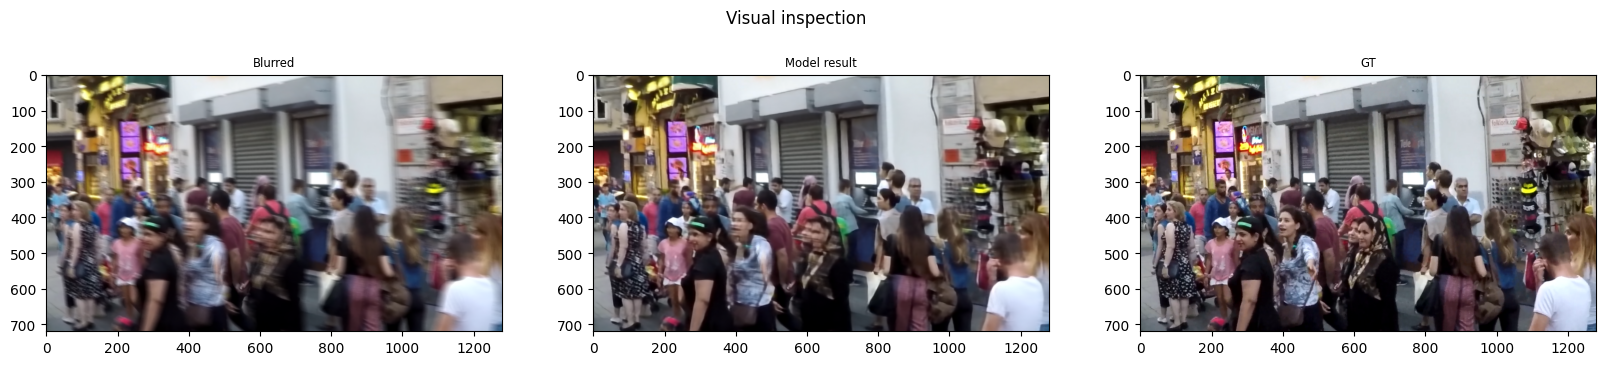

In [38]:
pics = test_dataset[0]
blurred, gt = pics[0], pics[1]
plt.figure(figsize=(20, 4))
plt.suptitle("Visual inspection")
plt.subplot(131)
plt.title("Blurred")
plt.imshow(blurred.permute(1, 2, 0))
plt.subplot(132)
plt.title("Model result")
with torch.no_grad():
    output = model(blurred.unsqueeze(0).to(device)).cpu().squeeze(0).permute(1, 2, 0).numpy()
output = np.clip(output, 0, 1)
plt.imshow(output)
plt.subplot(133)
plt.imshow(gt.permute(1, 2, 0))
plt.title("GT")
plt.show()